In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
import nltk

from elasticsearch import helpers, Elasticsearch
import csv
import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from inflection import singularize
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine as cs

In [3]:
df1 = pd.read_json('/Users/s0c02nj/Desktop/BioAsq_data/BioASQ-train-factoid-4b.json')
df2 = pd.read_json('/Users/s0c02nj/Desktop/BioAsq_data/BioASQ-train-factoid-5b.json')

df3 = pd.read_json('/Users/s0c02nj/Desktop/BioAsq_data/BioASQ-train-factoid-6b.json')

df4 = pd.read_json('/Users/s0c02nj/Downloads/BioASQ-67b-15Oct2019/BioASQ-7b/train/Full-Abstract/'+
                   'BioASQ-train-factoid-7b-full-annotated.json')

In [7]:
df1['data'].iloc[0]['paragraphs']

[{'qas': [{'id': '52bf208003868f1b06000019_002',
    'question': 'What is the inheritance pattern of Li–Fraumeni syndrome?',
    'answers': [{'text': 'autosomal dominant', 'answer_start': 213}]}],
  'context': 'Balanced t(11;15)(q23;q15) in a TP53+/+ breast cancer patient from a Li-Fraumeni syndrome family. Li-Fraumeni Syndrome (LFS) is characterized by early-onset carcinogenesis involving multiple tumor types and shows autosomal dominant inheritance. Approximately 70% of LFS cases are due to germline mutations in the TP53 gene on chromosome 17p13.1. Mutations have also been found in the CHEK2 gene on chromosome 22q11, and others have been mapped to chromosome 11q23. While characterizing an LFS family with a documented defect in TP53, we found one family member who developed bilateral breast cancer at age 37 yet was homozygous for wild-type TP53. Her mother also developed early-onset primary bilateral breast cancer, and a sister had unilateral breast cancer and a soft tissue sarcoma. C

In [3]:
l1 = len(df1['data'].iloc[0]['paragraphs'])
l2 = len(df2['data'].iloc[0]['paragraphs'])
l3 = len(df3['data'].iloc[0]['paragraphs'])
l4 = len(df4['data'].iloc[0]['paragraphs'])

In [4]:
def get_df(l,df) :

    question = []
    q_id = []
    ans = []

    for i in tqdm(range(0,l)):

        para = df['data'].iloc[0]['paragraphs'][i]
        qas = para['qas'][0]

        question.append(qas['question'])
        q_id.append(qas['id'])
        ans.append(para['context'])
        
    
    
    #Dataframe
    df_qa = pd.DataFrame()
    
    
    #dataframe
    df_qa['id'] = q_id
    df_qa['question'] = question
    df_qa['answer'] = ans

    return df_qa



In [5]:
df_qa1 = get_df(l1,df1)
df_qa2 = get_df(l2,df2)
df_qa3 = get_df(l3,df3)
df_qa4 = get_df(l4,df4)

100%|██████████| 5537/5537 [00:00<00:00, 70827.34it/s]


In [6]:
df_qa = pd.concat([df_qa1,df_qa2,df_qa3,df_qa4],sort=False)

In [7]:
df_qa = df_qa.drop(['id'],axis=1)

In [8]:
df_qa['answer'].nunique()

3022

In [9]:
df_qa_un = df_qa.drop_duplicates(keep='first')

In [10]:
df_qa_un['answer'].iloc[0]

'Balanced t(11;15)(q23;q15) in a TP53+/+ breast cancer patient from a Li-Fraumeni syndrome family. Li-Fraumeni Syndrome (LFS) is characterized by early-onset carcinogenesis involving multiple tumor types and shows autosomal dominant inheritance. Approximately 70% of LFS cases are due to germline mutations in the TP53 gene on chromosome 17p13.1. Mutations have also been found in the CHEK2 gene on chromosome 22q11, and others have been mapped to chromosome 11q23. While characterizing an LFS family with a documented defect in TP53, we found one family member who developed bilateral breast cancer at age 37 yet was homozygous for wild-type TP53. Her mother also developed early-onset primary bilateral breast cancer, and a sister had unilateral breast cancer and a soft tissue sarcoma. Cytogenetic analysis using fluorescence in situ hybridization of a primary skin fibroblast cell line revealed that the patient had a novel balanced reciprocal translocation between the long arms of chromosomes 1

In [11]:
def text_preprocessing(text):
    text= text.lower()
    text= re.sub(r'[^a-z]',' ',text)
    #text= " ".join([s for s in text.split() if len(s)>2])
    text= " ".join([x for x in text.split() if x not in stopwords.words('english')])
    #text= " ".join([inflection.singularize(x) for x in text.split()])
    text= text.strip()
    return(text)

In [12]:
tqdm.pandas()

In [13]:
df_qa_un['question'] = df_qa_un['question'].progress_apply(lambda x: text_preprocessing(x))
df_qa_un['answer'] =   df_qa_un['answer'].progress_apply(lambda x: text_preprocessing(x))

100%|██████████| 3052/3052 [00:07<00:00, 391.96it/s]
/Users/s0c02nj/anaconda2/envs/graph/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
100%|██████████| 3052/3052 [02:37<00:00, 19.43it/s]
/Users/s0c02nj/anaconda2/envs/graph/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
df_qa_un.index = range(0,len(df_qa_un))
df_qa_un = df_qa_un[1:]

In [15]:
df_qa_un.head()

,question,answer
1,inheritance pattern li fraumeni syndrome,genetic modeling li fraumeni syndrome zebrafis...
2,type lung cancer afatinib used,clinical perspective afatinib non small cell l...
3,hormone abnormalities characteristic pendred s...,doca sensitive pendrin expression kidney heart...
4,hormone abnormalities characteristic pendred s...,clinical molecular characteristics pendred syn...
5,hormone abnormalities characteristic pendred s...,pendred syndrome tunisia objectives report cli...


In [16]:
# df_qvec.head()

In [ ]:
# df_avec.head()


In [ ]:
#Loading the pretrained vecs
# df_qvec = pd.read_pickle('/Users/s0c02nj/Downloads/question.pkl')
# df_avec = pd.read_pickle('/Users/s0c02nj/Downloads/answer.pkl')

#### Creating Vector Dictionaries

In [17]:
# dict_qvec = {}
# dict_avec = {}

# for i in tqdm(range(0,len(df_qa_un))):
    
#     #ques and ans
#     qustn = df_qa_un['question'].iloc[i]
#     ans =  df_qa_un['answer'].iloc[i]
    
#     #vectors
#     qvec = df_qvec['embedding'].iloc[i]
#     avec = df_avec['embedding'].iloc[i]
    
#     #dict qs_vec
#     dict_qvec[qustn] = qvec
    
#     #dict ans_vec
#     dict_avec[ans] = avec
    
    
import pickle
    
#Loading
with open('/Users/s0c02nj/Downloads/dict_answer.pickle', 'rb') as handle:
    dict_avec = pickle.load(handle)
    
with open('/Users/s0c02nj/Downloads/dict_question.pickle', 'rb') as handle:
    dict_qvec = pickle.load(handle)

In [18]:
unique_ques = list(df_qa_un['question'].unique())
unique_ans =  list(df_qa_un['answer'].unique())

In [19]:
dict_ques = {}

for i,qs in enumerate(unique_ques):
    dict_ques[qs] = i   

In [20]:
dict_ans = {}

for i,ans in enumerate(unique_ans):
    dict_ans[ans] = i    

In [21]:
qid = []
pid = []


for i in tqdm(range(0,len(df_qa_un))):
    
    ques = df_qa_un['question'].iloc[i]
    ans = df_qa_un['answer'].iloc[i]
    
    qid.append(dict_ques[ques])
    pid.append(dict_ans[ans])

100%|██████████| 3051/3051 [00:00<00:00, 40346.63it/s]


In [22]:
df_qa_un['qid'] = qid
df_qa_un['pid'] = pid

In [23]:
df_qa_un.head()

,question,answer,qid,pid
1,inheritance pattern li fraumeni syndrome,genetic modeling li fraumeni syndrome zebrafis...,0,0
2,type lung cancer afatinib used,clinical perspective afatinib non small cell l...,1,1
3,hormone abnormalities characteristic pendred s...,doca sensitive pendrin expression kidney heart...,2,2
4,hormone abnormalities characteristic pendred s...,clinical molecular characteristics pendred syn...,2,3
5,hormone abnormalities characteristic pendred s...,pendred syndrome tunisia objectives report cli...,2,4


In [24]:
df_qa_un.shape

(3051, 4)

In [25]:
df_qa_un = df_qa_un.drop_duplicates(keep='first')

In [26]:
df_qa_un.shape

(3049, 4)

In [27]:
# df_qa_un['pid'].nunique()

In [28]:
# # df_qa_un.to_csv('/Users/s0c02nj/Desktop/Tuned_BioAsq_QA_dataset.csv',index = False)
# df_new =   df_qa_un.groupby('qid').head(10).reset_index(drop=True)

In [29]:
percent_match = []

for i in tqdm(range(0,len(df_qa_un))):
    
    ques_set = set(df_qa_un['question'].iloc[i].split())
    answer_set = set(df_qa_un['answer'].iloc[i].split())
    
    den = len(ques_set)
    num = len(ques_set.intersection(answer_set))
    
    per = (num/den) * 100
    
    percent_match.append(per)

100%|██████████| 3049/3049 [00:00<00:00, 16887.01it/s]


Text(0.5, 1.0, 'Frequency_Distribution')

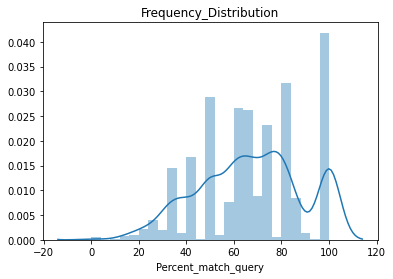

In [30]:
import seaborn as sns
sns.distplot(percent_match)

plt.xlabel('Percent_match_query')
plt.title('Frequency_Distribution')

In [31]:
df_qa_un['percent'] = percent_match

In [283]:
df_sub = df_qa_un[df_qa_un['percent'] < 80]

In [284]:
list_sub = list(df_sub['qid'].unique())

In [285]:
# #df_sub['question'].value_counts()
# #df_qa_un
# df_qa_un.to_pickle('/Users/s0c02nj/Desktop/Bioasq_subset_intersect.pkl')

In [286]:
df_sub['question'].nunique()

429

In [287]:
df_sub['question'].value_counts()

tyrosine kinase involved philadelphia chromosome positive chronic myelogenous leukemia target imatinib gleevec    68
transcriptional regulator bach activator repressor                                                                41
many tap isoforms identified humans                                                                               31
enzyme involved maintenance dna cytosine methylation                                                              30
characteristic domain histone methyltransferases                                                                  23
                                                                                                                  ..
targeted monoclonal antibody pembrolizumab                                                                         1
many amino acids davunetide consist                                                                                1
calcium channels ethosuximide target                            

In [288]:
# df_qa_un['qid'].nunique()
df_test = df_sub.drop_duplicates(keep='first')

In [289]:
df_test.head()

,question,answer,qid,pid,percent
1,inheritance pattern li fraumeni syndrome,genetic modeling li fraumeni syndrome zebrafis...,0,0,60.0
3,hormone abnormalities characteristic pendred s...,doca sensitive pendrin expression kidney heart...,2,2,40.0
4,hormone abnormalities characteristic pendred s...,clinical molecular characteristics pendred syn...,2,3,60.0
5,hormone abnormalities characteristic pendred s...,pendred syndrome tunisia objectives report cli...,2,4,60.0
6,hormone abnormalities characteristic pendred s...,patient pendred syndrome whose goiter progress...,2,5,40.0


In [290]:
df_test.head()

,question,answer,qid,pid,percent
1,inheritance pattern li fraumeni syndrome,genetic modeling li fraumeni syndrome zebrafis...,0,0,60.0
3,hormone abnormalities characteristic pendred s...,doca sensitive pendrin expression kidney heart...,2,2,40.0
4,hormone abnormalities characteristic pendred s...,clinical molecular characteristics pendred syn...,2,3,60.0
5,hormone abnormalities characteristic pendred s...,pendred syndrome tunisia objectives report cli...,2,4,60.0
6,hormone abnormalities characteristic pendred s...,patient pendred syndrome whose goiter progress...,2,5,40.0


#### Elactic Search

In [291]:
from elasticsearch import helpers, Elasticsearch
import csv
import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from inflection import singularize
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine as cs

In [292]:
es = Elasticsearch([{'host': 'localhost', 'port': 9200}])
es.info()

{'name': 'm-c02wv1jnhtd5',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'i0Q_KCKeTLGlRZzF8qt__A',
 'version': {'number': '7.6.2',
  'build_flavor': 'default',
  'build_type': 'tar',
  'build_hash': 'ef48eb35cf30adf4db14086e8aabd07ef6fb113f',
  'build_date': '2020-03-26T06:34:37.794943Z',
  'build_snapshot': False,
  'lucene_version': '8.4.0',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

In [293]:
index='index_30june'

In [294]:
def doc_generator(data,index):
    df_iter= data.iterrows()
    
    for index,document in df_iter:
        yield{
            "_index": 'index_30june',
            "_type": "_doc",
            "_id" : f"{index}",
            "_source": document.to_json()
        }
    raise StopIteration

In [295]:
for success,info in tqdm(helpers.parallel_bulk(es,doc_generator(df_qa_un[['pid','answer']],index))):
    if not success:
        print('A document failed:', info)
es.indices.refresh(index=index)

3049it [00:00, 3189.31it/s]


{'_shards': {'total': 2, 'successful': 1, 'failed': 0}}

In [296]:
def SEARCH(text,index,field):
    
    res= es.search(index=index,body={"query":{"match":{field:{"query":text,"operator":"or","fuzziness": "0"
                                                            }}}},size = 50)
    
    return([(x.get('_source'),x.get('_score')) for x in res['hits']['hits']])

In [297]:
index='index_30june'
field = 'answer'

In [298]:
#SEARCH('corporation',index,field)
question_un = list(df_sub['question'].unique())

df_ques = pd.DataFrame()
df_ques['question'] = question_un

In [299]:
df_ques['question'].nunique()

429

In [300]:
def query_generator(df):
    while True:
        yield (df_ques['question'])

In [301]:
query_generator(df_ques[['question']])

<generator object query_generator at 0x12ce75830>

In [302]:
import concurrent.futures

In [303]:
%%time

queries=[]
with concurrent.futures.ThreadPoolExecutor() as executor:
    queries={executor.submit(SEARCH, query,index,'answer'): query for query in tqdm(df_ques.question)}


100%|██████████| 429/429 [00:00<00:00, 2619.57it/s]


CPU times: user 726 ms, sys: 236 ms, total: 962 ms
Wall time: 904 ms


In [304]:
out = [x.result() for x in tqdm(queries)]

100%|██████████| 429/429 [00:00<00:00, 188335.40it/s]


In [305]:
def get_std_ref_match(data_current):
    
    #UPC to match
    questions = []
    
    #Original
    answers = []
    
    #Score
    score_bm25 = []
    
    #qid
    #qs_id = []
    
    #pid
    ps_id = []
    
        
    
    #Reindex
    data_current.index = range(0,len(data_current))
    
    
    for i in tqdm(range(0,len(data_current))):

            
            #question
            qs = data_current['question'].iloc[i]
            
           
            #Getting the search result
            temp_out = out[i]
            val = len(temp_out)

            if val ==0:
                
                #questions
                questions.append(qs)
                

                #answer
                answers.append('NA')
                
                #qs_id ps_9d
                #qs_id.append('NA')
                ps_id.append('NA')
                
                #Score
                score_bm25.append(0)
                
             
            else:
                for j in np.arange(val):

                    #clean_ingred
                    questions.append(qs)
                

                    #Creating temp
                    temp2 = temp_out[j]

                    #Separting the tuple
                    doc_txt = temp2[0]['answer']
                    
                    #qs_i = temp2[0]['qid']
                    ps_i = temp2[0]['pid']
                    
                    #query,passage ids
                    ps_id.append(ps_i)

                    #bm25
                    doc_scr = temp2[1]


                    #matched answers
                    answers.append(doc_txt)
                    

                    #Score
                    score_bm25.append(doc_scr)
                    
                    
                    
    

    #Converting to a Dataframe   
    df_out = pd.DataFrame()
    #df_result['qid'] = qs_id
    df_out['pid'] = ps_id
    df_out['question'] = questions
    df_out['answer'] = answers
    df_out['score'] = score_bm25

    return df_out



In [306]:
df_out = get_std_ref_match(df_ques)

100%|██████████| 429/429 [00:00<00:00, 9908.30it/s]


In [307]:
df_out['question'].value_counts()

oxantel used periodontitis treatment work                                  50
gene involved development barth syndrome                                   50
viliuisk encephalomyelitis diagnosed geographical area                     50
cellular process okazaki fragments associated                              50
type myeloma ixazomib evaluated                                            50
                                                                           ..
generic name gliolan                                                        8
name anorexia gymnasts                                                      8
vildagliptin sitagliptin saxagliptin alogliptin linagliptin dutogliptin     4
metahit stand                                                               4
mushroom poisonous amanita phalloides agaricus bisporus                     4
Name: question, Length: 429, dtype: int64

In [308]:
#q1 = df_ques['question'].iloc[3]

In [309]:
df_out.head()

,pid,question,answer,score
0,0,inheritance pattern li fraumeni syndrome,genetic modeling li fraumeni syndrome zebrafis...,19.096684
1,740,inheritance pattern li fraumeni syndrome,breast cancer phenotype women tp germline muta...,18.313347
2,1134,inheritance pattern li fraumeni syndrome,inducible transmissible genetic events pediatr...,14.657314
3,742,inheritance pattern li fraumeni syndrome,novel positive breast cancer phenotype arising...,14.311711
4,563,inheritance pattern li fraumeni syndrome,p guide apoptosis approximately sporadic human...,13.977517


In [310]:
df_out = df_out.drop_duplicates(keep='first')

In [311]:
#df_sub[df_sub['question'] == q1]
#df_out[df_out['question'] == q1]

In [312]:
#Bringing the unique qids
df_out['qid'] = df_out['question'].apply(lambda x : dict_ques[x])

In [313]:
df_out1 = df_out.sort_values(by=['question','score'],ascending = False)

In [314]:
df_out1['indices'] = range(0,len(df_out1))
df_out1['rank'] = (df_out1.groupby('question')['indices'].rank(ascending=True))
df_out1 = df_out1.drop(['indices'],axis=1)

In [315]:
df_pred = df_out1[['qid','pid','rank']]

In [316]:
df_pred['qid'].nunique()

429

In [317]:
df_true = df_sub[['qid','pid']]

In [318]:
def compute_metrics(df_true, df_pred, MaxMRRRank):
    
    """Compute MRR metric
    Assumptions: Ensure we have top 10 results for all the questions for the code sanity
    Sort the results by cosine similarity and give the top 10
    """
    all_scores = {}
    MRR = 0
    
    
    #list of true and predicted
    list1= list(set(df_pred['qid'].to_list()))
    list2= list(set(df_true['qid'].to_list()))
    
    
    for qid in list1:
        if qid in list2:
            #print (qid)
            target_pid = list(df_true[df_true['qid']==qid]['pid'])
            candidate_pid = list(df_pred[df_pred['qid']==qid]['pid'])
            rank_pid = list(df_pred[df_pred['qid']==qid]['rank'])
            
            for i in range(0,MaxMRRRank):
                #print (MaxMRRRank)
                if candidate_pid[i] in target_pid:
                    #print (i)
                    MRR += 1/(rank_pid[i] + 1)
                    #print (MRR)
                

    
    
    #calculating the final MRR
    MRR = MRR/len(list1)
    all_scores['MRR @10'] = MRR
    all_scores['QueriesRanked'] = len(list1)
    return all_scores

In [320]:
compute_metrics(df_true, df_pred,3)

{'MRR @10': 0.5561383061383074, 'QueriesRanked': 429}

In [246]:
MAX_RANK = 5

hits = pd.merge(df_true, df_pred,
    on=["qid", "pid"],
    how="left").fillna(MAX_RANK)



In [247]:
mrr_type2 = (1 / hits.groupby('qid')['rank'].min()).mean()
mrr_type2

0.30375818914787966

#### Word_vector based approach

In [248]:
df_out.head()

,pid,question,answer,score,qid
0,51,main regulatory molecule serca function cardia...,role serca pln complex ca homeostasis anti apo...,20.603191,8
2,108,main regulatory molecule serca function cardia...,serca genesis arrhythmias already know new rev...,20.036608,8
3,57,main regulatory molecule serca function cardia...,sarcoplasmic reticulum dynamic calcium governo...,18.549107,8
4,50,main regulatory molecule serca function cardia...,chronic phospholamban sarcoplasmic reticulum c...,18.356573,8
5,45,main regulatory molecule serca function cardia...,myotonic dystrophy protein kinase phosphorylat...,16.944004,8


In [249]:
#df_out = df_out.drop_duplicates(keep='first')

In [250]:
df1 = df_out.groupby('qid').agg({'answer': 'count'}).reset_index()

In [251]:
#df1.head()

In [252]:
df_inp = df_out[['qid','question','pid','answer']]

In [253]:
df_inp.shape

(3019, 4)

In [254]:
# def sent_vectorizer(sent_ls, model ,size):
    
#     sent_vec = np.zeros(size)
#     numw = 0
#     for w in sent_ls:
#         try:
#             sent_vec = np.add(sent_vec, model[w])
#             numw+=1
#         except:
#             pass
#     return sent_vec / np.sqrt(sent_vec.dot(sent_vec))

In [255]:
#dict_qvec['inheritance pattern li fraumeni syndrome'].shape

In [256]:
size = 768

In [257]:
df_inp_sub = df_inp[df_inp['qid'].isin(list_sub)]

In [258]:
df_inp_sub.head()

,qid,question,pid,answer
0,8,main regulatory molecule serca function cardia...,51,role serca pln complex ca homeostasis anti apo...
2,8,main regulatory molecule serca function cardia...,108,serca genesis arrhythmias already know new rev...
3,8,main regulatory molecule serca function cardia...,57,sarcoplasmic reticulum dynamic calcium governo...
4,8,main regulatory molecule serca function cardia...,50,chronic phospholamban sarcoplasmic reticulum c...
5,8,main regulatory molecule serca function cardia...,45,myotonic dystrophy protein kinase phosphorylat...


In [259]:
cosine = []

for i in tqdm(range(0,len(df_inp_sub))):
    
    query = df_inp_sub['question'].iloc[i]
    answer = df_inp_sub['answer'].iloc[i]
    
    q_vec = dict_qvec[query]
    a_vec = dict_avec[answer]
    
    cosine.append(1- cs(q_vec,a_vec))


100%|██████████| 3019/3019 [00:00<00:00, 8926.30it/s]


In [260]:
df_inp_sub['cosine'] = cosine

In [261]:
df_inp_sub.head()

,qid,question,pid,answer,cosine
0,8,main regulatory molecule serca function cardia...,51,role serca pln complex ca homeostasis anti apo...,0.652238
2,8,main regulatory molecule serca function cardia...,108,serca genesis arrhythmias already know new rev...,0.674531
3,8,main regulatory molecule serca function cardia...,57,sarcoplasmic reticulum dynamic calcium governo...,0.625972
4,8,main regulatory molecule serca function cardia...,50,chronic phospholamban sarcoplasmic reticulum c...,0.499073
5,8,main regulatory molecule serca function cardia...,45,myotonic dystrophy protein kinase phosphorylat...,0.574273


In [262]:
df_result_vec = df_inp_sub.sort_values(by=['question','cosine'],ascending = False)

In [263]:
df_result_vec['indices'] = range(0,len(df_result_vec))
df_result_vec['rank'] = (df_result_vec.groupby('question')['cosine'].rank(ascending=False))
df_result_vec = df_result_vec.drop(['indices'],axis=1)

In [264]:
df_pred_vec = df_result_vec[['qid','pid','rank']]

In [265]:
df_pred_vec.index = range(0,len(df_pred_vec))


In [266]:
df_true_vec = df_sub[['qid','pid']]

In [267]:
def compute_metrics(df_true, df_pred, MaxMRRRank):
    
    """Compute MRR metric
    Assumptions: Ensure we have top 10 results for all the questions for the code sanity
    Sort the results by cosine similarity and give the top 10
    """
    all_scores = {}
    MRR = 0
    
    
    #list of true and predicted
    list1= list(set(df_pred['qid'].to_list()))
    list2= list(set(df_true['qid'].to_list()))
    
    
    for qid in list1:
        if qid in list2:
            #print (qid)
            target_pid = list(df_true[df_true['qid']==qid]['pid'])
            candidate_pid = list(df_pred[df_pred['qid']==qid]['pid'])
            rank_pid = list(df_pred[df_pred['qid']==qid]['rank'])
            
            for i in range(0,MaxMRRRank):
                #print (MaxMRRRank)
                if candidate_pid[i] in target_pid:
                    #print (i)
                    MRR += 1/(rank_pid[i] + 1)
                    #print (MRR)
                

    
    
    #calculating the final MRR
    MRR = MRR/len(list1)
    all_scores['MRR'] = MRR
    all_scores['QueriesRanked'] = len(list1)
    return all_scores

In [274]:
compute_metrics(df_true_vec, df_pred_vec,10)

{'MRR': 0.1178635432667691, 'QueriesRanked': 62}

In [275]:
MAX_RANK = 10

hits = pd.merge(df_true_vec, df_pred_vec,
    on=["qid", "pid"],
    how="left").fillna(MAX_RANK)



In [276]:
mrr_type2 = (1 / hits.groupby('qid')['rank'].min()).mean()
mrr_type2

0.19648830137157902

In [277]:
df_true_vec.head()

,qid,pid
43,8,42
45,8,44
81,13,80
86,14,85
87,14,86


In [281]:
# df_pred_vec[df_pred_vec['qid'] == 8]

In [282]:
# hits